In [1]:
# -*- coding: utf-8 -*-
'''
Computa els canvis registrats en el taulell de joc i ho passa al Mòdul Control.
'''
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import time

In [2]:
def mostrarResultat(im,estatPartida,debug=False):
    for d in estatPartida:
        if debug:
            print(d,':',estatPartida[d])
        punts = estatPartida[d][1]
        x,y,w,h = estatPartida[d][0]
        orientacio = estatPartida[d][2]
        margin=20
        if orientacio == 0:
            x1=x-margin
            y1=y+int(h/2)
            x2=x+w
            y2=y+int(h/2)
            im =cv.putText(im,str(punts[0]),(x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2,cv.LINE_AA)
            im =cv.putText(im,str(punts[1]),(x2,y2), cv.FONT_HERSHEY_SIMPLEX, 1,(0,255,0),2,cv.LINE_AA)
        else:
            x1=x+int(w/2)
            y1=y
            x2=x+int(w/2)
            y2=y+h+margin
            im =cv.putText(im,str(punts[0]),(x1,y1), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv.LINE_AA)
            im =cv.putText(im,str(punts[1]),(x2,y2), cv.FONT_HERSHEY_SIMPLEX, 1,(255,0,0),2,cv.LINE_AA)            
        if debug:
            im =cv.putText(im,str(d),(x+int(w/2),(y+int(h/2))), cv.FONT_HERSHEY_SIMPLEX, 1,(0,0,255),2,cv.LINE_AA)
    im.astype('uint8')
    return im

In [3]:
def processarFrame(frame, debug=False):
    start = time.time()
    im = frame.copy()
    # Aplicar Threshold per obtenir imatge binaria
    ret,threshold = cv.threshold(frame,127,255,cv.THRESH_BINARY) 
    # Aplicar filtre Gaussia per eliminar el soroll
    threshold = cv.GaussianBlur(threshold, (5,5), 0) 
    
    # Creem imatge 2D per trobar-hi contorns 
    contorns = threshold[:,:,0]
    if debug :
        plt.figure()
        plt.imshow(contorns,'gray')
    # Trobem els contorns presents en la imatge (principalment les fitxes i els punts)
    contours, hierarchy = cv.findContours(contorns,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # contours -> Llista de contorns (llista de llistes de punts que formen cada contorn)
    # hierarchy ->Llista de relacions entre contorns
    # estructura de hierarchy -> [Next, Previous, First_Child, Parent]
    # el valor de cada camp referencia a un altre contorn
    # si no fa referencia a cap contorn, valor = -1 p.e si un contorn no te cap contorn dins : First_Child = -1
    
    # Creem un diccionari per desar les fitxes amb les seves dades
    dictContorns = {}
    # dictContorns = {idContorn: [cos,punts,orientacio]}
    #                 cos: [x, y, width, height]
    #                 punts: [puntsA, puntsB]
    #                 orientacio: 0 Horitzontal; 1 Vertical
    
    # Per cada contorn c
    for i,c in enumerate(contours):
        pare = hierarchy[0][i,3]
        # Si el contorn actual esta dins d'algun altre (es un punt)
        if pare != -1:
            # registrem les dades de la fitxa a la que pertany el punt a la variable cos
            # cos -> (x,y,width,height)
            cos = cv.boundingRect(contours[pare])
            # registrem les dades del punt actual
            x,y,w,h = cv.boundingRect(contours[i])
            punts=[0,0]
            orientacio=0
            #Comprovem l'orientacio de la fitxa i assignem el punt a un dels costats
            if cos[2] > cos[3]:
                # Horitzontal
                orientacio=0
                if x < cos[0]+int(cos[2]/2):
                    punts=[1,0] # Esquerra
                else:
                    punts=[0,1] # Dreta
            elif cos[2] < cos[3]:
                # Vertical
                orientacio=1
                if y < cos[1]+int(cos[3]/2):
                    punts=[1,0] # Superior
                else:
                    punts=[0,1] # Inferior
            else:
                print('Error!')
                pass          
            
            # Si la fitxa no existeix en el diccionari, la afegim amb totes les dades que hem recollit
            if not str(pare) in dictContorns:
                dictContorns[str(pare)]=[cos,punts,orientacio]
            # Si la fitxa si existeix, modifiquem el camp punts afegint el punt trobat al canto corresponent
            else:               
                dictContorns[str(pare)][1][0]+=punts[0]
                dictContorns[str(pare)][1][1]+=punts[1]
    if debug:
        print('Temps execució: %.3f segons' %(time.time()-start))
    return dictContorns

abans
despres
contorns: 21
[[[11 -1  1 -1]
  [ 2 -1 -1  0]
  [ 3  1 -1  0]
  [ 4  2 -1  0]
  [ 5  3 -1  0]
  [ 6  4 -1  0]
  [ 9  5  7  0]
  [ 8 -1 -1  6]
  [-1  7 -1  6]
  [10  6 -1  0]
  [-1  9 -1  0]
  [-1  0 12 -1]
  [13 -1 -1 11]
  [14 12 -1 11]
  [15 13 -1 11]
  [16 14 -1 11]
  [17 15 -1 11]
  [18 16 -1 11]
  [-1 17 19 11]
  [20 -1 -1 18]
  [-1 19 -1 18]]]
Temps execució: 0.290 segons


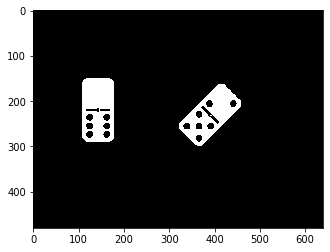

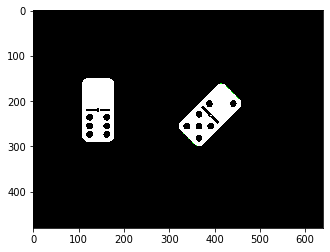

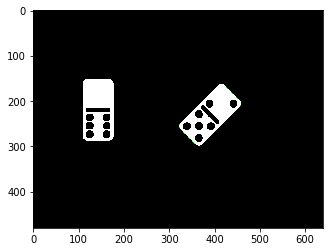

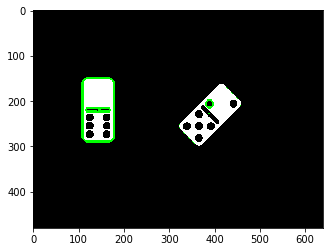

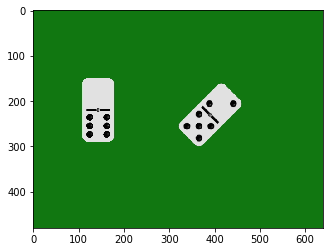

In [42]:

        

def processarFrame2(frame, debug=False):
    start = time.time()
    im = frame.copy()
    # Aplicar Threshold per obtenir imatge binaria
    ret,threshold = cv.threshold(frame,127,255,cv.THRESH_BINARY) 
    # Aplicar filtre Gaussia per eliminar el soroll
    #threshold = cv.GaussianBlur(threshold, (5,5), 0) 
    
    # Creem imatge 2D per trobar-hi contorns 
    contorns = threshold[:,:,0]
    if debug :
        plt.figure()
        plt.imshow(contorns,'gray')
    # Trobem els contorns presents en la imatge (principalment les fitxes i els punts)
    contours, hierarchy = cv.findContours(contorns,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    # contours -> Llista de contorns (llista de llistes de punts que formen cada contorn)
    # hierarchy ->Llista de relacions entre contorns
    # estructura de hierarchy -> [Next, Previous, First_Child, Parent]
    # el valor de cada camp referencia a un altre contorn
    # si no fa referencia a cap contorn, valor = -1 p.e si un contorn no te cap contorn dins : First_Child = -1
    
    # Creem un diccionari per desar les fitxes amb les seves dades
    dictContorns = {}
    # dictContorns = {idContorn: [cos,punts,orientacio]}
    #                 cos: [x, y, width, height]
    #                 punts: [puntsA, puntsB]
    #                 orientacio: 0 Horitzontal; 1 Vertical
    print('abans')
    plt.figure()
    plt.imshow(threshold,'gray')
    kernel = np.ones((3,3), np.uint8)
    threshold = cv.erode(threshold,kernel,iterations=1)
    print('despres')
    plt.figure()
    plt.imshow(threshold,'gray')
    
    # Per cada contorn c
    out = threshold.copy()
    print('contorns: {}'.format(len(hierarchy[0])))
    for i,c in enumerate(contours):
        if(hierarchy[0][i,0]==-1):
            cnt = contours[i]
            cv.drawContours(out, [cnt], 0, (0,255,0), 3)
    
    print(hierarchy)
    plt.figure()
    plt.imshow(out,'gray')
    
    if debug:
        print('Temps execució: %.3f segons' %(time.time()-start))
    return dictContorns

if __name__ == '__main__':
    frame = cv.imread('src/test1fitxa.jpg')    
    estatPartida = processarFrame2(frame,True)
    im=frame.copy()
    debug = True;
    if debug:
        plt.figure()
        plt.imshow(mostrarResultat(im,estatPartida))

nContorns:59
[[[30 -1  1 -1]
  [-1 -1  2  0]
  [ 5 -1  3  1]
  [-1 -1  4  2]
  [-1 -1 -1  3]
  [ 9  2  6  1]
  [-1 -1  7  5]
  [-1 -1  8  6]
  [-1 -1 -1  7]
  [13  5 10  1]
  [-1 -1 11  9]
  [-1 -1 12 10]
  [-1 -1 -1 11]
  [17  9 14  1]
  [-1 -1 15 13]
  [-1 -1 16 14]
  [-1 -1 -1 15]
  [21 13 18  1]
  [-1 -1 19 17]
  [-1 -1 20 18]
  [-1 -1 -1 19]
  [23 17 22  1]
  [-1 -1 -1 21]
  [26 21 24  1]
  [-1 -1 25 23]
  [-1 -1 -1 24]
  [-1 23 27  1]
  [-1 -1 28 26]
  [-1 -1 29 27]
  [-1 -1 -1 28]
  [-1  0 31 -1]
  [-1 -1 32 30]
  [35 -1 33 31]
  [-1 -1 34 32]
  [-1 -1 -1 33]
  [39 32 36 31]
  [-1 -1 37 35]
  [-1 -1 38 36]
  [-1 -1 -1 37]
  [43 35 40 31]
  [-1 -1 41 39]
  [-1 -1 42 40]
  [-1 -1 -1 41]
  [47 39 44 31]
  [-1 -1 45 43]
  [-1 -1 46 44]
  [-1 -1 -1 45]
  [51 43 48 31]
  [-1 -1 49 47]
  [-1 -1 50 48]
  [-1 -1 -1 49]
  [55 47 52 31]
  [-1 -1 53 51]
  [-1 -1 54 52]
  [-1 -1 -1 53]
  [-1 51 56 31]
  [57 -1 -1 55]
  [58 56 -1 55]
  [-1 57 -1 55]]]


True

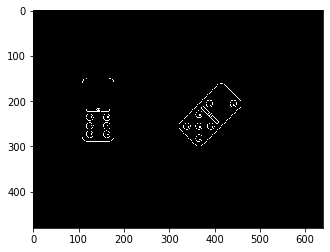

In [4]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

frame = cv.imread('src/test1fitxa.jpg')  
gray = cv.cvtColor(frame,cv.COLOR_BGR2GRAY)
edges = cv.Canny(gray,100,200)


contours,hierarchy = cv.findContours(edges,cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
print('nContorns:{}'.format(len(hierarchy[0])))
print(hierarchy)

plt.figure()
plt.imshow(edges,'gray')


cv.imwrite('edges.png',edges)

[[[11 -1  1 -1]
  [ 2 -1 -1  0]
  [ 3  1 -1  0]
  [ 4  2 -1  0]
  [ 5  3 -1  0]
  [ 6  4 -1  0]
  [ 9  5  7  0]
  [ 8 -1 -1  6]
  [-1  7 -1  6]
  [10  6 -1  0]
  [-1  9 -1  0]
  [-1  0 12 -1]
  [13 -1 -1 11]
  [14 12 -1 11]
  [15 13 -1 11]
  [16 14 -1 11]
  [17 15 -1 11]
  [18 16 -1 11]
  [-1 17 19 11]
  [20 -1 -1 18]
  [-1 19 -1 18]]]
Temps execució: 0.092 segons


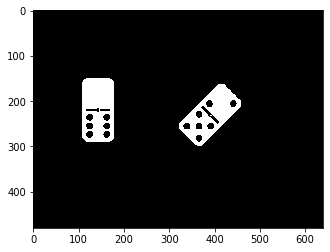

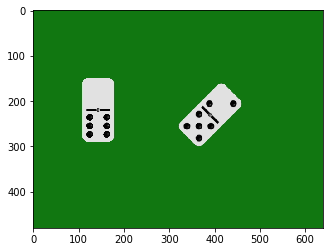

In [32]:
if __name__ == '__main__':
    frame = cv.imread('src/test1fitxa.jpg')    
    estatPartida = processarFrame2(frame,True)
    im=frame.copy()
    debug = True;
    if debug:
        plt.figure()
        plt.imshow(mostrarResultat(im,estatPartida))